### DATA 620 - Analysis of Bipartite Network (Project 2)

Author: Kory Martin  
Date: 3/10/2024

### 1. Introduction

#### Project Instructions

- Identify a large 2-node network dataset—you can start with a dataset in a repository. Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
- Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
- What can you infer about each of the distinct groups?
    

#### Project Plan

For this project, I chose to extend the work that I did on Assignment 3, using the a movieLens dataset [here](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). In this project, I adjusted the way in which I constructed the network. 

Overview:
This network is constructed to represent the relationships of movies that were watched and reviewed by the same person; thus allowing us to evaluate the popularity of individual films (i.e. films that watched in combination of different movies) and as an extension, the popularity of certain genres - based on the popularity of the films that are categorized as being in this genre.

As a recap, the network is constructed in the following manner:

- <b>Nodes</b>: Nodes represent individual movie titles
- <b>Edges</b>: The edges in the network represent movies that were watched by the same person. 

Finally, in the initial construction of the network, there were several movie raters who could be considered as "super viewers" based on the number of movies - within the entire set of movies watched - that they watched and rated. And for these users, their movie watching habits created a edges between movies that were most likely not representative of the movie watching habits of the overall network. Therefore to eliminate the disproprtionate impact of these "super viewers" the network was generated using the movie watching behavior of users who watched less than 2.5% of all of the films rated amongst all users.

Based on our network construction, we were then able to measure the degree centrality and eigenvector centrality for each node in the network (i.e. movie titles) and use this information to evaluate which films and genres could be considered as the most popular within the network.


### 2. Import Libraries

We begin by importing the necessary libraries for use in the cleaning of our data, the generation of our network, and our visualization of the data.

In [66]:
import networkx as net
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statistics import mean
import os.path
from plotnine import *

### 3. Data Preparation

We begin by importing the data for the specific movie titles that were being reviewed. Although this ultimately isn't something that will be included in the final network analysis, it was something that I had initially thought I wanted to specifically analyze. Additionally, the ratings data will be imported

In [2]:
movies_data = pd.read_csv('data/movies.csv')
ratings_data = pd.read_csv('data/ratings.csv')

Network conditions:
- Users who've viewed at least 5 movies but no more than 50 titles
- Titles that have been rated by at least 10 or more users

In [3]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Now that we have the movies and the ratings data imported, we will merge the two datasets so that we are able to track exactly which movie titles a specific user rated.

In [4]:
m1 = pd.merge(ratings_data, movies_data, how='left',
        left_on='movieId', right_on='movieId')

In [119]:
m1_simple = m1.loc[:,['title','userId','rating']]

In [270]:
m1_simple

,title,userId,rating
0,Toy Story (1995),1,4.0
1,Grumpier Old Men (1995),1,4.0
2,Heat (1995),1,4.0
3,Seven (a.k.a. Se7en) (1995),1,5.0
4,"Usual Suspects, The (1995)",1,5.0
...,...,...,...
100831,Split (2017),610,4.0
100832,John Wick: Chapter Two (2017),610,5.0
100833,Get Out (2017),610,5.0
100834,Logan (2017),610,5.0


In [319]:
unique_users = m1_simple.groupby('userId').agg({'title':'count'}).reset_index().sort_values(by='title').query("title <= 50").userId.unique().tolist()

In [320]:
m1_simple_filtered = m1_simple.loc[m1_simple['userId'].isin(unique_users)]

In [321]:
unique_titles = m1_simple_filtered.groupby('title').agg({'userId':'count'}).reset_index().query('userId > 10').title.unique().tolist()


In [251]:
m1_simple.groupby('userId').agg({'title':'count'})

,title
userId,
1,232
2,29
3,39
4,216
5,44
...,...
606,1115
607,187
608,831


In [297]:
m1_simple[m1_simple['userId'] == 442]

,title,userId,rating
68317,"Jungle Book, The (1994)",442,2.5
68318,Englishman Who Went Up a Hill But Came Down a ...,442,1.5
68319,Rudy (1993),442,2.0
68320,Heavy Metal (1981),442,1.0
68321,"Aristocats, The (1970)",442,1.5
68322,"Sex, Lies, and Videotape (1989)",442,1.0
68323,"Right Stuff, The (1983)",442,1.0
68324,Patton (1970),442,0.5
68325,I Know What You Did Last Summer (1997),442,0.5
68326,Dangerous Liaisons (1988),442,1.0


In [374]:
442 in unique_users

True

In [120]:
num_titles = len(m1_simple['title'].unique())

In [124]:
movie_count = m1_simple.groupby('userId').agg({'title':'count'}).reset_index()

In [125]:
movie_count['pct_total'] = moview_count.apply(lambda x: x['title']/num_titles,axis=1 )

In [246]:
temp_df = movie_count.sort_values(by='pct_total', ascending=False)

In [252]:
temp_df[temp_df['userId'] == 578]

,userId,title,pct_total
577,578,27,0.002778


In [356]:
temp_df = m1_simple_filtered.loc[(m1_simple_filtered['title'].isin(unique_titles)) & (m1_simple_filtered['userId'].isin(unique_users))]

In [377]:
unique_users = temp_df['userId'].unique().tolist()
unique_titles = temp_df['title'].unique().tolist()

In [355]:
temp_df[temp_df['userId'] == 442]

,title,userId,rating


In [362]:
user_movie_table = temp_df.pivot_table(index='title',columns='userId',values='rating',fill_value=0)

In [363]:
user_movie_table

userId,2,3,5,8,9,12,13,14,25,26,...,565,568,569,574,575,581,589,595,598,609
title,,,,,,,,,,,,,,,,,,,,,
Ace Ventura: Pet Detective (1994),0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,...,3.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
Addams Family Values (1993),0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Aladdin (1992),0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
Alien (1979),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aliens (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WALL·E (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
Waterworld (1995),0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
While You Were Sleeping (1995),0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0


In [341]:
pd.crosstab(temp_df['title'],temp_df['userId'],margins='All').sort_values(by='All')

userId,2,3,5,8,9,12,13,14,25,26,...,568,569,574,575,581,589,595,598,609,All
title,,,,,,,,,,,,,,,,,,,,,
"Piano, The (1993)",0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,11
"Shining, The (1980)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
"Time to Kill, A (1996)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
Executive Decision (1996),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
Mystery Science Theater 3000: The Movie (1996),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Silence of the Lambs, The (1991)",0,0,0,1,0,0,0,1,0,1,...,1,0,1,0,0,1,0,1,0,61
Pulp Fiction (1994),0,0,1,1,0,0,0,1,0,1,...,1,1,1,1,0,1,0,0,1,66
Forrest Gump (1994),0,0,0,1,0,0,0,1,0,1,...,1,1,0,0,1,1,0,0,1,70


In [354]:
temp_df[temp_df['userId']==442]

,title,userId,rating


In [326]:
temp_df.pivot_table(index='userId',columns='title',values='rating',fill_value=0,margins='All')

title,Ace Ventura: Pet Detective (1994),Addams Family Values (1993),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),Apollo 13 (1995),Avatar (2009),...,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),While You Were Sleeping (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000),All
userId,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,3.937500
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
5,3.000000,3.00000,4.000000,0.000000,0.000000,0.000000,0.00,0.000000,3.000000,0.000000,...,0.000000,0.000000,0.000,4.0000,0.000000,0.000000,0.000000,0.000000,0.000000,3.413793
8,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,4.000000,0.000000,...,3.000000,0.000000,0.000,5.0000,0.000000,3.000000,3.000000,0.000000,0.000000,3.657143
9,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,4.000000,0.000000,...,0.000000,5.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,4.304348
595,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,5.0000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000
598,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000


In [378]:
rows = len(user_movie_table.index)
columns = len(user_movie_table.columns)

In [390]:
user_movie_table.iloc[1,2]

3.0

In [391]:
biadjacency_matrix = []

for i in range(rows):
    for j in range(columns):
        if user_movie_table.iloc[i,j] > 0:
            #mini_tupt = (i,user_movie_table.columns[j],user_movie_table.iloc[i,j])
            mini_tupt = (user_movie_table.index[i],user_movie_table.columns[j],user_movie_table.iloc[i,j])
            print(mini_tupt)
            biadjacency_matrix.append(mini_tupt)

('Ace Ventura: Pet Detective (1994)', 5, 3.0)
('Ace Ventura: Pet Detective (1994)', 14, 2.0)
('Ace Ventura: Pet Detective (1994)', 26, 3.0)
('Ace Ventura: Pet Detective (1994)', 31, 3.0)
('Ace Ventura: Pet Detective (1994)', 37, 5.0)
('Ace Ventura: Pet Detective (1994)', 46, 3.0)
('Ace Ventura: Pet Detective (1994)', 56, 5.0)
('Ace Ventura: Pet Detective (1994)', 72, 3.5)
('Ace Ventura: Pet Detective (1994)', 81, 1.0)
('Ace Ventura: Pet Detective (1994)', 107, 3.0)
('Ace Ventura: Pet Detective (1994)', 124, 3.5)
('Ace Ventura: Pet Detective (1994)', 126, 1.0)
('Ace Ventura: Pet Detective (1994)', 130, 4.0)
('Ace Ventura: Pet Detective (1994)', 134, 3.0)
('Ace Ventura: Pet Detective (1994)', 142, 4.0)
('Ace Ventura: Pet Detective (1994)', 145, 2.0)
('Ace Ventura: Pet Detective (1994)', 146, 2.0)
('Ace Ventura: Pet Detective (1994)', 170, 3.0)
('Ace Ventura: Pet Detective (1994)', 176, 2.0)
('Ace Ventura: Pet Detective (1994)', 242, 3.0)
('Ace Ventura: Pet Detective (1994)', 255, 5.0)
('

In [450]:
G = net.Graph()

In [451]:
G.add_nodes_from(unique_titles,bipartite=0)
G.add_nodes_from(unique_users,bipartite=1)

In [452]:
#G.add_edges_from(biadjacency_matrix)
G.add_weighted_edges_from(biadjacency_matrix)

In [453]:
net.is_bipartite(G)

True

In [454]:
net.is_connected(G)

True

In [455]:
botom_nodes, top_nodes = bipartite.sets(G)

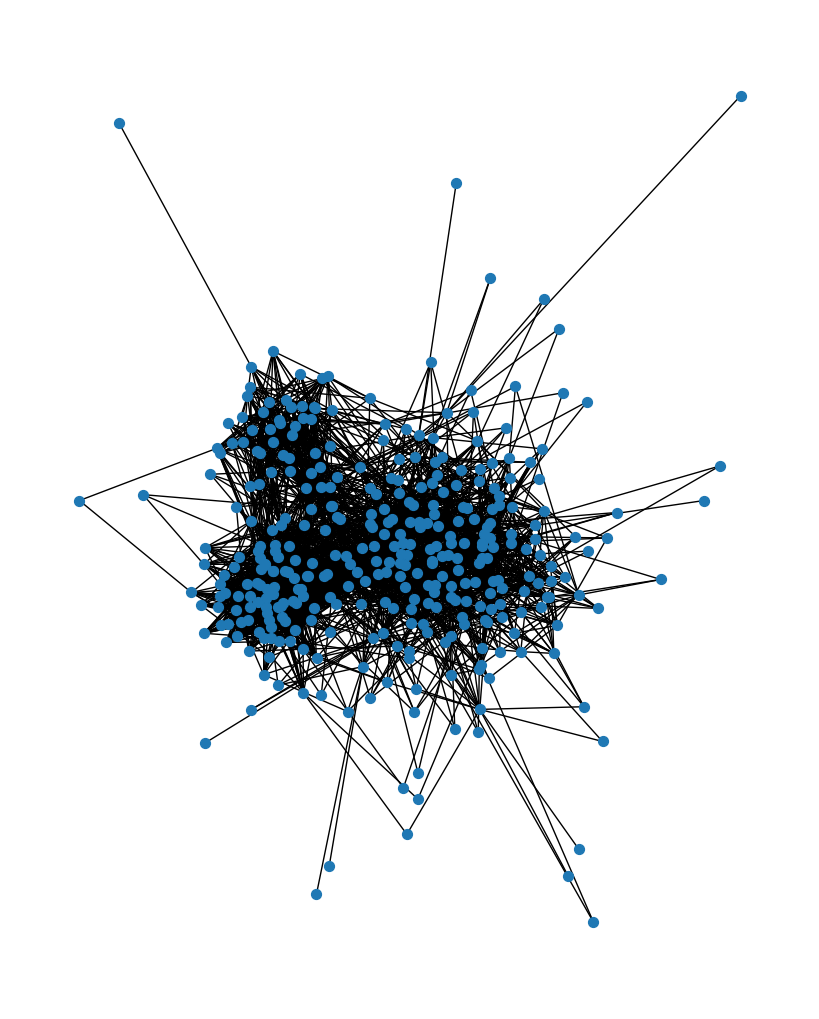

In [462]:
pos = net.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
plt.figure(figsize=(8,10))
net.draw(G, pos, node_size=50,)
plt.show()

Projection on Unique Users

In [463]:
U = bipartite.projected_graph(G,unique_users)

for user in unique_users:
    print(f"{user} {U.degree(user)} ")

2 123 
3 60 
5 173 
8 178 
9 65 
12 29 
13 117 
14 178 
25 156 
26 132 
30 170 
31 159 
35 103 
37 170 
44 110 
46 171 
48 116 
49 154 
54 175 
55 13 
56 172 
60 140 
61 174 
65 145 
67 173 
69 179 
71 135 
72 195 
77 127 
81 167 
85 62 
87 20 
97 149 
106 127 
107 159 
114 127 
118 153 
120 127 
124 190 
126 156 
127 33 
128 155 
130 156 
133 179 
134 143 
138 21 
142 168 
145 155 
146 66 
147 27 
148 133 
150 95 
154 112 
155 162 
157 86 
161 122 
162 165 
163 29 
164 149 
170 173 
172 147 
173 154 
175 10 
176 170 
180 108 
185 126 
188 100 
189 164 
192 131 
193 189 
196 167 
197 170 
203 155 
205 119 
206 109 
207 37 
208 139 
209 182 
214 84 
218 61 
228 149 
231 183 
236 34 
237 181 
238 84 
242 168 
243 145 
245 27 
250 103 
251 166 
252 91 
253 41 
255 101 
257 70 
258 140 
259 135 
269 101 
270 110 
271 81 
272 141 
276 154 
277 113 
278 110 
281 60 
283 177 
285 108 
289 25 
291 103 
293 112 
295 158 
296 155 
299 70 
300 166 
302 159 
311 65 
315 11 
319 168 
320 38 
324 62

In [469]:
pd.DataFrame([{'user':user,'degree':U.degree(user)} for user in unique_users]).sort_values(by='degree', ascending=False).reset_index(drop=True)

,user,degree
0,399,197
1,72,195
2,400,194
3,443,193
4,513,191
...,...,...
217,55,13
218,499,11
219,315,11
220,431,10


In [464]:
U = bipartite.weighted_projected_graph(G,unique_users)

for user in unique_users:
    print(f"{user} {U.degree(user,weight='weight')} ")



2 220 
3 63 
5 949 
8 1127 
9 106 
12 29 
13 186 
14 958 
25 460 
26 690 
30 611 
31 586 
35 357 
37 742 
44 352 
46 1046 
48 185 
49 423 
54 963 
55 13 
56 1091 
60 253 
61 432 
65 400 
67 696 
69 603 
71 479 
72 1110 
77 438 
81 939 
85 69 
87 20 
97 322 
106 297 
107 823 
114 216 
118 351 
120 342 
124 722 
126 1233 
127 35 
128 323 
130 879 
133 1074 
134 765 
138 21 
142 974 
145 772 
146 89 
147 27 
148 306 
150 360 
154 183 
155 352 
157 121 
161 161 
162 652 
163 31 
164 413 
170 1075 
172 264 
173 713 
175 10 
176 987 
180 240 
185 207 
188 119 
189 573 
192 632 
193 677 
196 459 
197 555 
203 491 
205 174 
206 393 
207 46 
208 341 
209 629 
214 271 
218 83 
228 300 
231 574 
236 37 
237 438 
238 122 
242 939 
243 579 
245 27 
250 111 
251 550 
252 124 
253 42 
255 158 
257 99 
258 299 
259 231 
269 276 
270 475 
271 105 
272 263 
276 557 
277 318 
278 178 
281 70 
283 552 
285 150 
289 27 
291 210 
293 161 
295 415 
296 538 
299 103 
300 525 
302 660 
311 73 
315 11 
319 598 

In [468]:
pd.DataFrame([{'user':user,'degree':U.degree(user,weight='weight')} for user in unique_users]).sort_values(by='degree', ascending=False).reset_index(drop=True)

,user,degree
0,512,1273
1,126,1233
2,8,1127
3,72,1110
4,347,1110
...,...,...
217,55,13
218,315,11
219,499,11
220,431,10


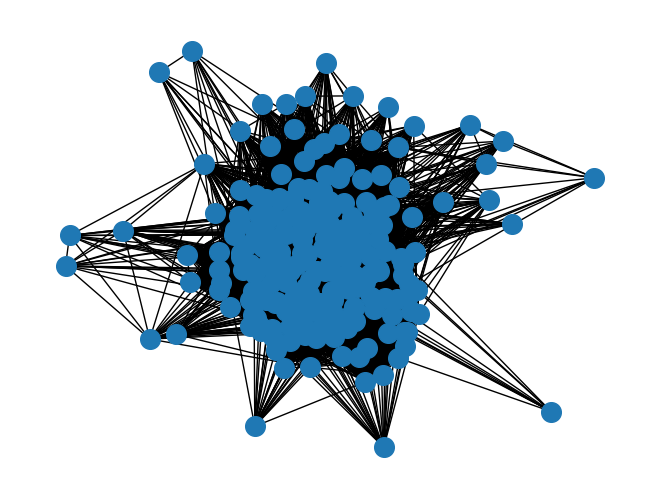

In [405]:
pos = net.spring_layout(U, seed=648)  # Seed layout for reproducible node positions
net.draw(U,pos,node_size=200)
plt.show()

Projection on Movie Titles

In [489]:
T = bipartite.projected_graph(G,unique_titles)

for title in unique_titles:
    print(f"{title} {T.degree(title)} ")

Shawshank Redemption, The (1994) 131 
Good Will Hunting (1997) 76 
Gladiator (2000) 92 
Departed, The (2006) 67 
Dark Knight, The (2008) 80 
Inglourious Basterds (2009) 64 
Inception (2010) 72 
Interstellar (2014) 66 
Schindler's List (1993) 127 
Requiem for a Dream (2000) 67 
Toy Story (1995) 130 
Babe (1995) 79 
Dead Man Walking (1995) 96 
Clueless (1995) 72 
Usual Suspects, The (1995) 120 
Braveheart (1995) 128 
Apollo 13 (1995) 112 
Batman Forever (1995) 97 
Interview with the Vampire: The Vampire Chronicles (1994) 64 
Legends of the Fall (1994) 88 
Pulp Fiction (1994) 130 
Quiz Show (1994) 68 
Stargate (1994) 84 
Ace Ventura: Pet Detective (1994) 108 
Clear and Present Danger (1994) 84 
Lion King, The (1994) 106 
Mask, The (1994) 89 
True Lies (1994) 84 
Addams Family Values (1993) 73 
Fugitive, The (1993) 117 
Aladdin (1992) 111 
Terminator 2: Judgment Day (1991) 126 
Dances with Wolves (1990) 103 
Batman (1989) 100 
Beauty and the Beast (1991) 91 
Pretty Woman (1990) 78 
Fargo (

In [472]:
pd.DataFrame([{'title':title,'degree':T.degree(title)} for title in unique_titles]).sort_values(by='degree', ascending=False).reset_index(drop=True)

,title,degree
0,Forrest Gump (1994),132
1,"Shawshank Redemption, The (1994)",131
2,Toy Story (1995),130
3,Pulp Fiction (1994),130
4,"Silence of the Lambs, The (1991)",129
...,...,...
129,"Time to Kill, A (1996)",54
130,Harry Potter and the Prisoner of Azkaban (2004),53
131,Avatar (2009),45
132,Executive Decision (1996),43


In [415]:
T = bipartite.weighted_projected_graph(G,unique_titles)

for title in unique_titles:
    print(f"{title} {T.degree(title,weight='weight')} ")

Shawshank Redemption, The (1994) 1540 
Good Will Hunting (1997) 217 
Gladiator (2000) 315 
Departed, The (2006) 194 
Dark Knight, The (2008) 374 
Inglourious Basterds (2009) 156 
Inception (2010) 447 
Interstellar (2014) 216 
Schindler's List (1993) 920 
Requiem for a Dream (2000) 145 
Toy Story (1995) 764 
Babe (1995) 402 
Dead Man Walking (1995) 304 
Clueless (1995) 372 
Usual Suspects, The (1995) 676 
Braveheart (1995) 1256 
Apollo 13 (1995) 1075 
Batman Forever (1995) 873 
Interview with the Vampire: The Vampire Chronicles (1994) 597 
Legends of the Fall (1994) 408 
Pulp Fiction (1994) 1380 
Quiz Show (1994) 513 
Stargate (1994) 701 
Ace Ventura: Pet Detective (1994) 957 
Clear and Present Danger (1994) 732 
Lion King, The (1994) 569 
Mask, The (1994) 509 
True Lies (1994) 882 
Addams Family Values (1993) 394 
Fugitive, The (1993) 956 
Aladdin (1992) 822 
Terminator 2: Judgment Day (1991) 931 
Dances with Wolves (1990) 1011 
Batman (1989) 1020 
Beauty and the Beast (1991) 652 
Pret

In [473]:
pd.DataFrame([{'title':title,'degree':T.degree(title,weight='weight')} for title in unique_titles]).sort_values(by='degree', ascending=False).reset_index(drop=True)

,title,degree
0,"Shawshank Redemption, The (1994)",1540
1,Pulp Fiction (1994),1380
2,Forrest Gump (1994),1369
3,Braveheart (1995),1256
4,"Silence of the Lambs, The (1991)",1177
...,...,...
129,Harry Potter and the Prisoner of Azkaban (2004),130
130,Mystery Science Theater 3000: The Movie (1996),114
131,Butch Cassidy and the Sundance Kid (1969),107
132,Harry Potter and the Half-Blood Prince (2009),102


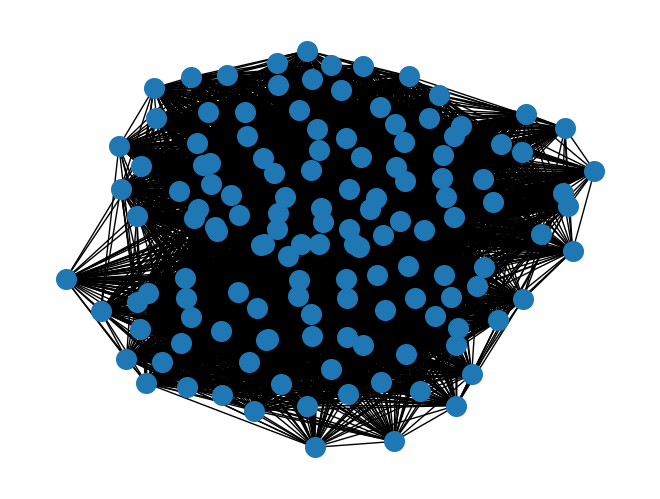

In [409]:
pos = net.spring_layout(T, seed=648)  # Seed layout for reproducible node positions
net.draw(T,pos,node_size=200)
plt.show()

In [432]:
titles_set = bipartite.sets(G)[0]
users_set = bipartite.sets(G)[1]

In [481]:
pd.DataFrame([{'title':key, 'centrality':value} for key, value in bipartite.degree_centrality(T,users_set).items()]).sort_values(by='centrality', ascending=False)
    

,title,centrality
34,Forrest Gump (1994),0.594595
67,"Shawshank Redemption, The (1994)",0.590090
17,Pulp Fiction (1994),0.585586
84,Toy Story (1995),0.585586
36,"Silence of the Lambs, The (1991)",0.581081
...,...,...
72,"Time to Kill, A (1996)",0.243243
91,Harry Potter and the Prisoner of Azkaban (2004),0.238739
127,Avatar (2009),0.202703
73,Harry Potter and the Half-Blood Prince (2009),0.193694


In [496]:
pd.DataFrame([{'title':key, 'centrality':value} for key, value in bipartite.closeness_centrality(T,unique_titles).items()]).sort_values(by='centrality', ascending=False)

,title,centrality
34,Forrest Gump (1994),1.985075
67,"Shawshank Redemption, The (1994)",1.970370
17,Pulp Fiction (1994),1.955882
84,Toy Story (1995),1.955882
36,"Silence of the Lambs, The (1991)",1.941606
...,...,...
72,"Time to Kill, A (1996)",1.254717
91,Harry Potter and the Prisoner of Azkaban (2004),1.248826
127,Avatar (2009),1.203620
2,Executive Decision (1996),1.192825


### 3. Calculate the Centrality

Next, we use the built-in functions in NetworkX to calculate the Degree Centrality and Eigenvector Centrality values for each of the nodes in our network and we will join these values to our overall network data

#### Degree Centrality

In [66]:
degree_centrality = net.degree_centrality(G)

centrality_list = []
centrality_list.append(degree_centrality)

degree_centrality_df = pd.DataFrame(centrality_list).transpose().reset_index()
degree_centrality_df = degree_centrality_df.rename(columns={'index':'title',0:'centrality'})

In [67]:
degree_centrality_df.head(10)

,title,centrality
0,Toy Story (1995),0.594727
1,Grumpier Old Men (1995),0.224402
2,Heat (1995),0.353771
3,Seven (a.k.a. Se7en) (1995),0.489884
4,"Usual Suspects, The (1995)",0.532189
5,From Dusk Till Dawn (1996),0.255263
6,Bottle Rocket (1996),0.121398
7,Braveheart (1995),0.578582
8,Rob Roy (1995),0.251788
9,Canadian Bacon (1995),0.099121


#### Eigenvector Centrality

In [55]:
eigenvector_centrality = net.eigenvector_centrality(G)

centrality_list = []
centrality_list.append(eigenvector_centrality)

eigenvector_centrality_df = pd.DataFrame(centrality_list).transpose().reset_index()
eigenvector_centrality_df = eigenvector_centrality_df.rename(columns={'index':'title',0:'centrality'})

In [56]:
eigenvector_centrality_df.head(10)

,title,centrality
0,Toy Story (1995),0.047037
1,Grumpier Old Men (1995),0.023855
2,Heat (1995),0.035039
3,Seven (a.k.a. Se7en) (1995),0.042372
4,"Usual Suspects, The (1995)",0.044370
5,From Dusk Till Dawn (1996),0.026699
6,Bottle Rocket (1996),0.014707
7,Braveheart (1995),0.046197
8,Rob Roy (1995),0.026107
9,Canadian Bacon (1995),0.012468


### 4. Basic Network Analysis

<b> a. How many nodes are included in the network?

In [34]:
len(list(G.nodes()))

4894

In [72]:
len(movies_data['title'].unique())

9737

In [73]:
4984/9737

0.511861969805895

There are 4,894 nodes in this network, representing just over 51% of the 9,737 movies that were rated overall.

<b> b. What is the size of the Graph?

In [74]:
G.size()

1145704

There are a total of 1,145,704 connections between the movies that were viewed

<b> c.  What is the average and median number of neighbors for nodes?

In [75]:
num_neighbors = [len(list(net.neighbors(G,user))) for user in list(G.nodes())]
numbers_group = [{'title':user, 'num_neighbors':len(list(net.neighbors(G,user)))} for user in list(G.nodes())]

In [76]:
mean_neighbors = mean(num_neighbors)
median_neighbors = np.median(num_neighbors)

In [78]:
print("Mean # of Neighbors per Film: ", mean_neighbors)
print("Median # of Neighbors per Film: ", median_neighbors)

Mean # of Neighbors per Film:  468.20760114425826
Median # of Neighbors per Film:  262.5


In our network, the average film was watched alongside an average of 262.5 different movies - or stated differently, the average film in the network was watched in conjunction with 1 of 262.5 different movies at some point. This is siginificantly lower than the media for the network, suggesting that there are a significant number of movies that are rare and are not watched along with other films - resulting in our network being significantly left-skewed.

<b>d. What is the largest number of neighbors that any particular node has?

In [79]:
max_neighbors = max(num_neighbors)
max_neighbors

3426

In [80]:
max_neighbors/len(list(G.nodes()))

0.7000408663669799

The largest number of neighbors that any particular node has is 3,426. This means that this movie was watched alongside 70% of the titles included in our network

<b>e. What node(s) has the largest number of neighbors?


In [41]:
nodes_with_max = [user for user in list(G.nodes()) if len(list(net.neighbors(G,user))) == max_neighbors]
nodes_with_max

['Matrix, The (1999)']

The movie 'The Matrix' would be considered the most popular movie in our dataset based on this metric

<b>f. What is the fewest number of neighbors that any particular node has?

In [82]:
min_neighbors = min(num_neighbors)
min_neighbors

19

<b>h. What node(s) has the fewest number of neighbors?

In [83]:
nodes_with_min = [user for user in list(G.nodes()) if len(list(net.neighbors(G,user))) == min_neighbors]
nodes_with_min

['Spies Like Us (1985)', 'District 13 (Banlieue 13) (2004)']

There were 2 movies in our network that were watched with 1 of 19 different other film titles

### 5. Analysis of Network Centrality

Finally, we will create a new dataframe that combines the centrality measures along with the general movie information so that we can conduct further analysis on the network

In [84]:
neighbors_df = pd.DataFrame(numbers_group)
neighbors_df = pd.merge(neighbors_df, degree_centrality_df, how='left').rename(columns={'centrality':'degree'})
neighbors_df = pd.merge(neighbors_df, eigenvector_centrality_df, how='left').rename(columns={'centrality':'eigenvector'})

Here we will filter out the movies that are not included in the network

In [85]:
movies_filtered = movies_expanded_df[movies_expanded_df['title'].isin(m1_sub_titles)]
neighbors_expanded = pd.merge(movies_filtered.loc[:,['genre','title']],neighbors_df, how='left')

Next we create a summary table to understand the different summary metrics for the titles based on genre.

In [88]:
summary_table = neighbors_expanded.groupby('genre').agg(
    num_titles = ('title','count'),
    median_neighbors = ('num_neighbors','median'),
    mean_neighbors = ('num_neighbors','mean'),
    max_neighbors = ('num_neighbors','max'),
    min_neighbors = ('num_neighbors','min'),
    median_degree = ('degree','median'),
    mean_degree = ('degree','mean'),
    max_degree = ('degree','max'),
    min_degree = ('degree','min'),
    median_eigen = ('eigenvector','median'),
    mean_eigen = ('eigenvector','mean'),
    max_eigen = ('eigenvector','max'),
    min_eigen = ('eigenvector','min')
    
).reset_index().sort_values(by='max_degree', ascending=False)

In [104]:
summary_table['pct_total'] = summary_table['num_titles']/len(list(G.nodes()))

In [105]:
summary_table.sort_values(by='pct_total', ascending=False)

,genre,num_titles,median_neighbors,mean_neighbors,max_neighbors,min_neighbors,median_degree,mean_degree,max_degree,min_degree,median_eigen,mean_eigen,max_eigen,min_eigen,pct_total
8,Drama,2254,252.0,450.492458,3419,20,0.051502,0.092069,0.698753,0.004087,0.006473,0.010157,0.050478,0.000175,0.460564
5,Comedy,1812,289.0,482.525938,3419,19,0.059064,0.098616,0.698753,0.003883,0.007234,0.010818,0.050478,0.000175,0.370249
17,Thriller,1062,322.5,525.063089,3426,20,0.065910,0.107309,0.700184,0.004087,0.008172,0.011822,0.050229,0.000175,0.217000
1,Action,1032,396.5,600.646318,3426,19,0.081034,0.122756,0.700184,0.003883,0.010040,0.013316,0.050229,0.000276,0.210870
15,Romance,909,313.0,507.547855,3419,20,0.063969,0.103729,0.698753,0.004087,0.007499,0.011204,0.050478,0.000175,0.185738
2,Adventure,805,436.0,644.226087,3250,20,0.089107,0.131663,0.664214,0.004087,0.010883,0.014121,0.049499,0.000415,0.164487
6,Crime,608,320.5,554.279605,3353,19,0.065502,0.113280,0.685265,0.003883,0.008065,0.012323,0.049426,0.000378,0.124234
16,Sci-Fi,579,419.0,624.616580,3426,19,0.085633,0.127655,0.700184,0.003883,0.010222,0.013602,0.050229,0.000175,0.118308
9,Fantasy,475,373.0,573.454737,2910,21,0.076231,0.117199,0.594727,0.004292,0.009090,0.012573,0.047037,0.000431,0.097058
11,Horror,460,230.0,384.504348,3211,21,0.047006,0.078583,0.656244,0.004292,0.005340,0.008583,0.048782,0.000175,0.093993


<b>a. Most prominent genre - based on number of titles</b>

As shown in the chart above, we see that Drama is the most prominent genre of films in our network, with over 2200 different titles being viewed, representing 46% of the movie titles included in the network

In [283]:
fig = px.bar(summary_table.sort_values(by='num_titles'), x='num_titles', y='genre', text='num_titles',
            labels={'num_titles':'Number of Titles',
                   'genre':'Genre'})
#fig.update_layout(uniformtext_minsize=8)
fig.update_traces(texttemplate='%{x:2,}')
fig.update_layout(
    title={
        'text': "Most Prominent Genres - Based on Number of Titles",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

<b>b. Most popular genre - based on Degree Centrality</b>

However, when we evaluate the films based on degree centrality, we see that Sci-Fi, Thriller, and Action categories have the title with the highest measure of degree centrality. 
    

In [364]:
top_genre_dc = summary_table.sort_values(by='max_degree', ascending=False).loc[:,['genre','max_degree']]. \
 reset_index(drop=True).head(10)

In [365]:
top_genre_dc

,genre,max_degree
0,Sci-Fi,0.700184
1,Thriller,0.700184
2,Action,0.700184
3,War,0.698753
4,Romance,0.698753
5,Drama,0.698753
6,Comedy,0.698753
7,Crime,0.685265
8,Adventure,0.664214
9,Horror,0.656244


<b> c. Most popular film title - based on Degree Centrality</b>

When looking at the most popular titles based on Degree Centrality, we see that this distinction is actually held by one film, 'The Matrix', which we saw earlier had the most number of neighbors, but it is also included in three different categories

In [115]:
neighbors_expanded.sort_values(by='degree', ascending=False).head(10)

,genre,title,num_neighbors,degree,eigenvector
3619,Thriller,"Matrix, The (1999)",3426,0.700184,0.050229
3618,Sci-Fi,"Matrix, The (1999)",3426,0.700184,0.050229
3617,Action,"Matrix, The (1999)",3426,0.700184,0.050229
601,War,Forrest Gump (1994),3419,0.698753,0.050478
598,Comedy,Forrest Gump (1994),3419,0.698753,0.050478
599,Drama,Forrest Gump (1994),3419,0.698753,0.050478
600,Romance,Forrest Gump (1994),3419,0.698753,0.050478
498,Comedy,Pulp Fiction (1994),3353,0.685265,0.049426
499,Crime,Pulp Fiction (1994),3353,0.685265,0.049426
500,Drama,Pulp Fiction (1994),3353,0.685265,0.049426


<b> d. Top 10 titles (irrespective of genre) - based on Degree Centrality

In [140]:
top_titles_dc = neighbors_expanded. \
drop_duplicates(subset = ['title']).sort_values(by='degree', ascending=False).head(10)

In [141]:
top_titles_dc.loc[:,['title','num_neighbors','degree']].reset_index(drop=True)

,title,num_neighbors,degree
0,"Matrix, The (1999)",3426,0.700184
1,Forrest Gump (1994),3419,0.698753
2,Pulp Fiction (1994),3353,0.685265
3,Star Wars: Episode IV - A New Hope (1977),3250,0.664214
4,"Silence of the Lambs, The (1991)",3211,0.656244
5,"Shawshank Redemption, The (1994)",3147,0.643164
6,Star Wars: Episode V - The Empire Strikes Back...,3021,0.617413
7,American Beauty (1999),3010,0.615165
8,Back to the Future (1985),2955,0.603924
9,"Godfather, The (1972)",2946,0.602085


In [275]:
fig = px.bar(top_titles_dc.sort_values(by='degree'), x='degree', y='title', 
             text='degree',title='Top 10 Titles by Degree Centrality',
            labels={'degree':'Degree Centrality Measure',
                   'title':''},
            text_auto = '.3f')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
#fig.update_traces(texttemplate="%{degree:$.2f}")

fig.show()


<b> e. Bottom 10 titles (irrespective of genre) - based on Degree Centrality

In [126]:
bottom_titles = neighbors_expanded. \
drop_duplicates(subset = ['title']).sort_values(by='degree', ascending=False).tail(10)

In [129]:
bottom_titles.loc[:,['title','num_neighbors','degree']].reset_index(drop=True)

,title,num_neighbors,degree
0,"One I Love, The (2014)",20,0.004087
1,Samsara (2011),20,0.004087
2,Laggies (2014),20,0.004087
3,Delirium (2014),20,0.004087
4,"Host, The (2013)",20,0.004087
5,"Lifeguard, The (2013)",20,0.004087
6,Insurgent (2015),20,0.004087
7,Godzilla 2000 (Gojira ni-sen mireniamu) (1999),20,0.004087
8,Spies Like Us (1985),19,0.003883
9,District 13 (Banlieue 13) (2004),19,0.003883


<b>f. Most popular genre - based on Eigenvector Centrality</b>

When we evaluate the films based on eigenvector centrality, we see that War, Romance, Drama and Comedy categories have the title with the highest measure of eigenvector centrality. 
    

In [366]:
top_genre_ec = summary_table.sort_values(by='max_eigen', ascending=False).loc[:,['genre','max_eigen']]. \
 reset_index(drop=True).head(10)

In [367]:
top_genre_ec

,genre,max_eigen
0,War,0.050478
1,Romance,0.050478
2,Drama,0.050478
3,Comedy,0.050478
4,Sci-Fi,0.050229
5,Thriller,0.050229
6,Action,0.050229
7,Adventure,0.049499
8,Crime,0.049426
9,Horror,0.048782


<b> g. Most popular film title - based on Eigenvector Centrality</b>

When looking at the most popular titles based on Eigenvector Centrality, we see that 'Forrest Gump' replaces 'The Matrix' for the top spots, while 'Star Wars: Episode IV' becomes a new entrant into the group.

In [131]:
neighbors_expanded.sort_values(by='eigenvector', ascending=False).head(10)

,genre,title,num_neighbors,degree,eigenvector
598,Comedy,Forrest Gump (1994),3419,0.698753,0.050478
599,Drama,Forrest Gump (1994),3419,0.698753,0.050478
600,Romance,Forrest Gump (1994),3419,0.698753,0.050478
601,War,Forrest Gump (1994),3419,0.698753,0.050478
3617,Action,"Matrix, The (1999)",3426,0.700184,0.050229
3618,Sci-Fi,"Matrix, The (1999)",3426,0.700184,0.050229
3619,Thriller,"Matrix, The (1999)",3426,0.700184,0.050229
440,Action,Star Wars: Episode IV - A New Hope (1977),3250,0.664214,0.049499
441,Adventure,Star Wars: Episode IV - A New Hope (1977),3250,0.664214,0.049499
442,Sci-Fi,Star Wars: Episode IV - A New Hope (1977),3250,0.664214,0.049499


<b> h. Top 10 titles (irrespective of genre) - based on Eigenvector Centrality

In [138]:
top_titles_ec = neighbors_expanded. \
drop_duplicates(subset = ['title']).sort_values(by='eigenvector', ascending=False).head(10)

In [139]:
top_titles_ec.loc[:,['title','num_neighbors','eigenvector']].reset_index(drop=True)

,title,num_neighbors,eigenvector
0,Forrest Gump (1994),3419,0.050478
1,"Matrix, The (1999)",3426,0.050229
2,Star Wars: Episode IV - A New Hope (1977),3250,0.049499
3,Pulp Fiction (1994),3353,0.049426
4,"Silence of the Lambs, The (1991)",3211,0.048782
5,"Shawshank Redemption, The (1994)",3147,0.048215
6,Star Wars: Episode V - The Empire Strikes Back...,3021,0.048106
7,Saving Private Ryan (1998),2939,0.047290
8,Star Wars: Episode VI - Return of the Jedi (1983),2922,0.047257
9,Back to the Future (1985),2955,0.047135


In [274]:
fig = px.bar(top_titles_dc.sort_values(by='eigenvector'), 
             x='eigenvector', 
             y='title', 
             text='eigenvector',
            title='Top 10 Titles by Eigenvector Centrality',
            labels={'eigenvector':'Eigenvector Centrality Measure',
                   'title':''},
            text_auto = '0.3f')
fig.show()


<b> i. Bottom 10 titles (irrespective of genre) - based on Eigenvector Centrality

In [136]:
bottom_titles = neighbors_expanded. \
drop_duplicates(subset = ['title']).sort_values(by='eigenvector', ascending=False).tail(10)

In [137]:
bottom_titles.loc[:,['title','num_neighbors','eigenvector']].reset_index(drop=True)

,title,num_neighbors,eigenvector
0,Stay (2005),23,0.000175
1,Raise Your Voice (2004),23,0.000175
2,Silent Running (1972),23,0.000175
3,You Got Served (2004),23,0.000175
4,Meteor (1979),23,0.000175
5,Raising Helen (2004),23,0.000175
6,Me and You and Everyone We Know (2005),23,0.000175
7,When a Stranger Calls (2006),23,0.000175
8,Take the Lead (2006),23,0.000175
9,Step Up 2 the Streets (2008),23,0.000175


In [51]:
neighbors_expanded[neighbors_expanded['genre'] == 'Drama'].sort_values(by='degree', ascending=False).head(10)

,genre,title,num_neighbors,degree,eigenvector
599,Drama,Forrest Gump (1994),3419,0.698753,0.050478
500,Drama,Pulp Fiction (1994),3353,0.685265,0.049426
535,Drama,"Shawshank Redemption, The (1994)",3147,0.643164,0.048215
3955,Drama,American Beauty (1999),3010,0.615165,0.046755
1255,Drama,"Godfather, The (1972)",2946,0.602085,0.046215
2856,Drama,Saving Private Ryan (1998),2939,0.600654,0.047290
208,Drama,Braveheart (1995),2831,0.578582,0.046197
3850,Drama,"Sixth Sense, The (1999)",2815,0.575312,0.045859
862,Drama,Schindler's List (1993),2787,0.569589,0.045543
4088,Drama,Fight Club (1999),2734,0.558757,0.044346


In [52]:
neighbors_expanded.sort_values(by='degree', ascending=False)

,genre,title,num_neighbors,degree,eigenvector
3619,Thriller,"Matrix, The (1999)",3426,0.700184,0.050229
3618,Sci-Fi,"Matrix, The (1999)",3426,0.700184,0.050229
3617,Action,"Matrix, The (1999)",3426,0.700184,0.050229
601,War,Forrest Gump (1994),3419,0.698753,0.050478
598,Comedy,Forrest Gump (1994),3419,0.698753,0.050478
...,...,...,...,...,...
10499,Documentary,Samsara (2011),20,0.004087,0.000902
7780,Comedy,Spies Like Us (1985),19,0.003883,0.000378
8305,Action,District 13 (Banlieue 13) (2004),19,0.003883,0.000378
8306,Crime,District 13 (Banlieue 13) (2004),19,0.003883,0.000378


In [108]:
top10_titles = neighbors_expanded.sort_values(by='degree', ascending=False).drop_duplicates(subset=['title']).head(10)


In [109]:
top10_titles

,genre,title,num_neighbors,degree,eigenvector
3619,Thriller,"Matrix, The (1999)",3426,0.700184,0.050229
601,War,Forrest Gump (1994),3419,0.698753,0.050478
498,Comedy,Pulp Fiction (1994),3353,0.685265,0.049426
440,Action,Star Wars: Episode IV - A New Hope (1977),3250,0.664214,0.049499
970,Crime,"Silence of the Lambs, The (1991)",3211,0.656244,0.048782
534,Crime,"Shawshank Redemption, The (1994)",3147,0.643164,0.048215
1711,Sci-Fi,Star Wars: Episode V - The Empire Strikes Back...,3021,0.617413,0.048106
3955,Drama,American Beauty (1999),3010,0.615165,0.046755
1897,Adventure,Back to the Future (1985),2955,0.603924,0.047135
1255,Drama,"Godfather, The (1972)",2946,0.602085,0.046215


<b>j. Top 10 Titles </b>
- Number of Neighbors 
- Degree Centrality
- Eigenvector Centrality

In [142]:
top_titles_neighbors = neighbors_expanded. \
drop_duplicates(subset = ['title']).sort_values(by='num_neighbors', ascending=False).head(10)

In [287]:
a = top_titles_neighbors.loc[:,['title']].reset_index(drop=True)

In [288]:
b = top_titles_dc.loc[:,['title']].reset_index(drop=True)

In [289]:
c = top_titles_ec.loc[:,['title']].reset_index(drop=True)

In [290]:
a['rank'] = a.reset_index().index+1
b['rank'] = b.reset_index().index+1
c['rank'] = c.reset_index().index+1

In [291]:
a = a.rename(columns={'title':'Title - Group A'})
b = b.rename(columns={'title':'Title - Group B'})
c = c.rename(columns={'title':'Title - Group C'})

In [163]:
m1 = pd.merge(a,b)
m2 = pd.merge(m1,c)

In [173]:
movie_rank = m2.loc[:,['rank','Title - Group A','Title - Group B','Title - Group C']].rename(columns={'rank':
                                                                                        'Rank'})

In [174]:
movie_rank

,Rank,Title - Group A,Title - Group B,Title - Group C
0,1,"Matrix, The (1999)","Matrix, The (1999)",Forrest Gump (1994)
1,2,Forrest Gump (1994),Forrest Gump (1994),"Matrix, The (1999)"
2,3,Pulp Fiction (1994),Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977)
3,4,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994)
4,5,"Silence of the Lambs, The (1991)","Silence of the Lambs, The (1991)","Silence of the Lambs, The (1991)"
5,6,"Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994)","Shawshank Redemption, The (1994)"
6,7,Star Wars: Episode V - The Empire Strikes Back...,Star Wars: Episode V - The Empire Strikes Back...,Star Wars: Episode V - The Empire Strikes Back...
7,8,American Beauty (1999),American Beauty (1999),Saving Private Ryan (1998)
8,9,Back to the Future (1985),Back to the Future (1985),Star Wars: Episode VI - Return of the Jedi (1983)
9,10,"Godfather, The (1972)","Godfather, The (1972)",Back to the Future (1985)


In [299]:
unique_titles = pd.concat([a['Title - Group A'],b['Title - Group B'],c['Title - Group C']]).unique()

In [353]:
rank_titles = []
for title in unique_titles:
    mini_dict = {}
    
    if title in list(b['Title - Group B']):
        rank_degree = b[b['Title - Group B'] == title]['rank'].values[0]
    else:
        rank_degree = "-"
        
    if title in list(c['Title - Group C']):
        rank_eigen = c.loc[c['Title - Group C'] == title]['rank'].values[0]
    else:
        rank_eigen = "-"
    
    mini_dict['title'] = title
    mini_dict['rank_degree'] = rank_degree
    mini_dict['rank_eigen'] = rank_eigen
    #print(mini_dict)
    rank_titles.append(mini_dict)

In [362]:
top_titles_ranking = pd.DataFrame(rank_titles).sort_values(by='title').reset_index(drop=True).rename(columns={'title':'Move Title',
                                                                                        'rank_degree':'Degree Rank',
                                                                                        'rank_eigen':'Eigenvector Rank'})

<b> Top movie titles based on Degree Centrality Rank and Eigenvector Centrality Rank</b>

In [363]:
top_titles_ranking

,Move Title,Degree Rank,Eigenvector Rank
0,American Beauty (1999),8,-
1,Back to the Future (1985),9,10
2,Forrest Gump (1994),2,1
3,"Godfather, The (1972)",10,-
4,"Matrix, The (1999)",1,2
5,Pulp Fiction (1994),3,4
6,Saving Private Ryan (1998),-,8
7,"Shawshank Redemption, The (1994)",6,6
8,"Silence of the Lambs, The (1991)",5,5
9,Star Wars: Episode IV - A New Hope (1977),4,3


<b> k. Histogram of degree centrality for the entire network</b>

In [240]:
a = neighbors_expanded.drop_duplicates(subset=['title'])

In [242]:
fig = px.histogram(a, x="degree",labels={'degree':'Degree Centrality Measure',
                                             'count':'Number of Titles'},nbins=50)

fig.update_layout(
    title={
        'text': "Histogram of Degree Centrality Across Network",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

<b> l. Histogram of degree centrality for the entire network</b>

In [189]:
a = neighbors_expanded.drop_duplicates(subset=['title'])

In [238]:
fig = px.histogram(a, x="eigenvector",labels={'eigenvector':'Eigenvector Centrality Measure',
                                             'count':'Number of Titles'},nbins=50)

fig.update_layout(
    title={
        'text': "Histogram of Eigenvector Centrality Across Network",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

<b> Comparative rankings of genres based on Degree Centrality and Eigenvector Centrality Measures

In [381]:
top_genres = list(pd.concat([top_genre_dc['genre'],top_genre_ec['genre']]).unique())

In [391]:
top_genre_dc['rank'] = top_genre_dc.reset_index().index+1
top_genre_ec['rank'] = top_genre_ec.reset_index().index+1

In [392]:
top_genres_list = []
for genre in top_genres:
    
    mini_dict = {}
    
    if genre in list(top_genre_dc['genre']):
        dc_rank = top_genre_dc[top_genre_dc['genre'] == genre]['rank'].values[0]
    else:
        dc_rank = "-"
    
    if genre in list(top_genre_ec['genre']):
        ec_rank = top_genre_ec[top_genre_ec['genre'] == genre]['rank'].values[0]
    else:
        ec_rank = "-"
    
    mini_dict['genre'] = genre
    mini_dict['dc_rank'] = dc_rank
    mini_dict['ec_rank'] = ec_rank
    top_genres_list.append(mini_dict)

In [394]:
genre_rankings = pd.DataFrame(top_genres_list).sort_values(by='genre').rename(columns={'genre':'Genre',
                                                                                      'dc_rank': 'Degree Rank',
                                                                                      'ec_rank':'Eigenvector Rank'})

In [399]:
genre_rankings['Absolute Difference'] = genre_rankings.apply(lambda x: abs(x['Degree Rank'] - x['Eigenvector Rank']), axis=1)

In [405]:
np.mean(genre_rankings['Absolute Difference'])

2.6

In [404]:
np.median(genre_rankings['Absolute Difference'])

3.0

In [407]:
genre_rankings.reset_index(drop=True)

,Genre,Degree Rank,Eigenvector Rank,Absolute Difference
0,Action,3,7,4
1,Adventure,9,8,1
2,Comedy,7,4,3
3,Crime,8,9,1
4,Drama,6,3,3
5,Horror,10,10,0
6,Romance,5,2,3
7,Sci-Fi,1,5,4
8,Thriller,2,6,4
9,War,4,1,3


### 6. Conclusion

This review of the network, revealed some pretty interesting things about our data. Overall, we found that the most popular titles - based on degree centrality and number of neighbors for a node - represented movies that are generally considered as being fairly common titles. Overall, I don't think that there were any suprises with respect to the titles that appear in our list. 

However, I found it interesting to observe how vastly different the lists of popular titles were between the Degree Centrality and Eigenvector Centrality measures. Again, there wasn't much shock in terms of the titles that were included in these two lists, as much as the fact that there were different movies in the Top 10 of the respective lists that did not appear in the other list. As shown in the table above, <b>Saving Private Ryan</b> and <b>Stars Wars: Episode VI</b> did not make the Top-10 list based on Degree Centrality; while <b>American Beauty</b> and <b>The Godfather</b> did not make the list based on Eigenvector Centrality.

Lastly, we see that while the same genres cracked the Top-10 list based on their Degree Centrality and Eigenvector Centrality measures, Horror is the only genre that had the same positioning in both lists. However, the mean absolute difference in the rankings for genres between their ranking based on each measure of centrality was 2.6, while the median absolute difference was 3.0